In [1]:
from analysis import *
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.widgets as widgets
import xml.etree.ElementTree as ET
import multiprocessing as mp

In [4]:
traj = md.load('traj.dcd', top='start.hoomdxml')[-100:]
traj.center_coordinates()
anchor_molecules = [mol for mol in traj.top.find_molecules() if len(mol) > 2]
traj.image_molecules(inplace=True, anchor_molecules=anchor_molecules)

# Load system information
system = [['ecer3', 66],
          ['chol', 68],
          ['ffa24', 66],
          ['water', 2000]]

traj = load_system(traj, system)
n_frames = traj.n_frames

print('Loaded trajectory with {} frames'.format(n_frames))

# Get masses from hoomdxml
tree = ET.parse('start.hoomdxml')
root = tree.getroot()
masses = np.fromstring(root[0][3].text, sep='\n')

Loaded trajectory with 100 frames


In [28]:
def smoothing(hist, bins, window):
    bins_new = [np.mean(bins[i+int(window/2):i+int(3*window/2)]) for i in range(len(bins)-window)]
    hist_new = [np.mean(hist[i+int(window/2):i+int(3*window/2)]) for i in range(len(bins)-window)]
    return np.array(hist_new), np.array(bins_new)

def density_plot(atomselection, n_frames, window):
    atoms = traj.top.select(atomselection) # which atoms to plot
    box_length = np.mean([traj.unitcell_lengths[-(n_frames):,2]])

    hist, edges = np.histogram(traj.xyz[-(n_frames):, atoms, 2].reshape(-1), weights=np.tile(masses.take(atoms), n_frames), 
                               range=[-.001,box_length+.001], bins=400)
    bins = (edges[1:]+edges[:-1]) / 2.0
    print((bins[1]-bins[0]) * 6)
    hist *= 0.55409730 / 1000 / n_frames # multiply by cg density unit
    hist /= np.mean(traj.unitcell_lengths[-(n_frames):,0]**2) * (bins[1]-bins[0]) # divide by volume of slice
    bins *= 6
    hist, bins = smoothing(hist, bins, window)
    plt.plot(bins, hist)

def plot_conformation(residues):
    residues = np.array(residues)
    ind = np.array([0, molecule[resname][0], molecule[resname][0]+5])
    indices = ind.T[:] + residues[:,np.newaxis]
    
    angles = md.compute_angles(traj, indices) * 180/ np.pi
    angles = angles.reshape((1,-1))
    
    hist, edges = np.histogram(angles, bins=100, range=[0,180])
    bins = (edges[1:] + edges[:-1])/2

    plt.plot(bins, hist)

    hairpin = len(['None' for angle in angles[0] if angle < 90])
    extended = len(['None' for angle in angles[0] if angle > 90])
    hairpin /= len(angles[0]) / 100
    extended /= len(angles[0]) / 100
    print("Ceramide Conformation: \nHairpin:  {0:.3f} %\nExtended: {1:.3f} %".format(hairpin, extended))


0.029266282110214235


Text(0,0.5,'density (g/mL)')

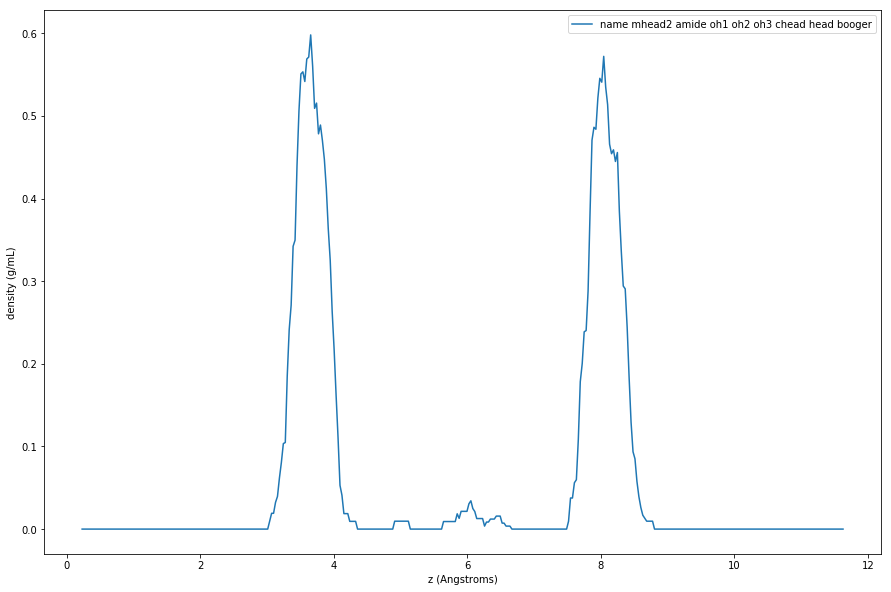

In [30]:
plt.figure(figsize=(15, 10))

#sels = ['not name water']
sels = ['name mhead2 amide oh1 oh2 oh3 chead head booger']
#sels = ['resname ecer3 and name tail', 'resname ffa18 and name tail', 'resname chol and name ring ctail']

for sel in sels:
    density_plot(sel, 1, 8)

height = []
for frame in traj:
    points_sorted = calc_maxs(frame, sels[0], 1, 8)
    peaks = []
    n_layers = 2
    for i in points_sorted:
        if len(peaks) == 0:
            peaks += [i[1]]
        else:
            for j in peaks:
                if np.abs(j-i[1]) > 3:
                    peaks += [i[1]]
        if len(peaks) == n_layers:
            break
        
    peaks.sort()
    peaks = np.array(peaks)
    height += [np.mean(peaks[1:] - peaks[:-1])]

plt.legend(sels)
plt.xlabel('z (Angstroms)')
plt.ylabel('density (g/mL)')

In [3]:
apl = np.loadtxt('apl.txt') 
tilt = np.loadtxt('tilt.txt')
s2 = np.loadtxt('s2.txt')

print('Area per Lipid:\t{0:.3f} +/- {1:.3f}'.format(np.mean(apl), np.std(apl)))
print('Tilt Angle:\t{0:.3f} +/- {1:.3f}'.format(np.mean(tilt), np.std(tilt)))
print('S2:\t\t{0:.3f} +/- {1:.3f}'.format(np.mean(s2), np.std(s2)))
print("")

for i in [0, 1]:
    print('Area per Lipid:\t{0:.3f} +/- {1:.3f}'.format(np.mean(apl[:,i]), np.std(apl[:,i])))
    print('Tilt Angle:\t{0:.3f} +/- {1:.3f}'.format(np.mean(tilt[:,i]), np.std(tilt[:,i])))
    print('S2:\t\t{0:.3f} +/- {1:.3f}'.format(np.mean(s2[:,i]), np.std(s2[:,i])))
    print("")


Area per Lipid:	0.336 +/- 0.009
Tilt Angle:	12.788 +/- 1.255
S2:		0.903 +/- 0.019



In [46]:
peaks = [11.201376930141446, 7.0407696899414045, ]
peaks.sort()
peaks = np.array(peaks)
print(np.mean(peaks[1:] - peaks[:-1]))

4.997131076717379


Ceramide Conformation: 
Hairpin:  57.333 %
Extended: 42.667 %


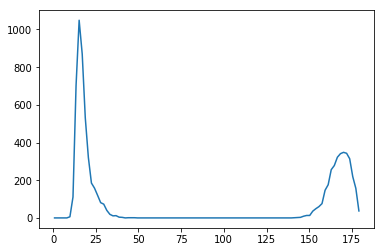

In [85]:
resname = 'ecer3'
min = 9 /6
max = 12 /6
residues = np.array([residue.atom(0).index for residue in traj.top.residues if residue.name == resname
                    if min < np.mean(traj.xyz[:, residue.atom(molecule[resname][0]).index, 2]) < max])
plot_conformation(residues)

In [41]:
masses = np.fromstring(root[0][3].text, sep='\n')

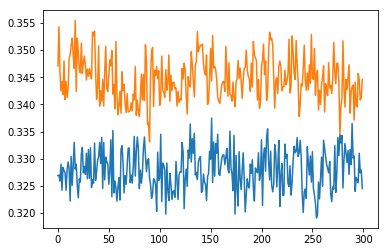

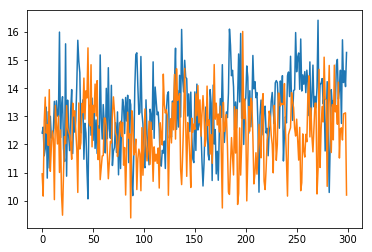

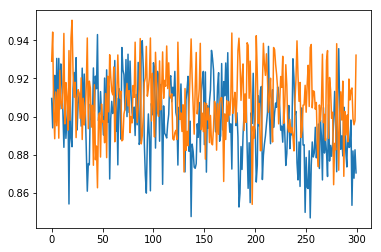

In [4]:
plt.figure(0)
plt.plot(apl)
plt.figure(1)
plt.plot(tilt)
plt.figure(2)
plt.plot(s2)

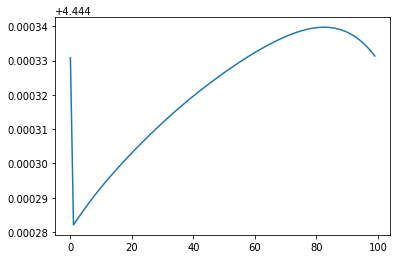

In [73]:
data = sds
sds = [np.mean(data[-i:]) for i in range(len(data))]
plt.plot(sds)
#plt.ylim([np.std(data)-.05*np.std(data),np.std(data)+.05*np.std(data)])

In [61]:
1/np.e

0.36787944117144233

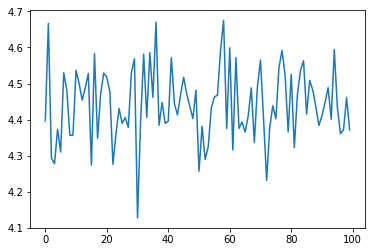

In [32]:
plt.plot(height)